<center>
<img src="FIFA-19-Background-1-768x401.jpg" />
    
## Aprendizaje No Supervisado 2020 DiploDatos
    Laura Alonso Alemany, Ana Georgina Flesia y Valeria Rulloni
## Agrupamiento con el FIFA 2019 dataset
    
Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros.

### Indice de temas
1. [Inicialización del entorno](#1.-Inicialización-del-entorno)
2. [Preparación de los datos](#2.-Preparación-de-los-datos)
3. [Clustering KM](#3.-Clustering-con-Kmeans)
4. [Clustering MS](#4.-Clustering-con-Mean-Shift)
5. [Clustering KM2](#5.-Clustering-con-Kmeans-sin-arqueros)
6. [Clustering MS2](#6.-Clustering-con-Mean-Shift-sin-arqueros)

## 1.-Inicialización-del-entorno

Empezamos cargando algunas herramientas para cargar los datos y manipularlos.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

Para visualización usamos plotly, pero podemos usar seaborn tambien, o matplotlib. 

In [2]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

## 2.-Preparación-de-los-datos

Cargamos los datos bajados de la database de [Kaggle](https://www.kaggle.com/karangadiya/fifa19) como 'data.csv'. 

In [3]:
df=pd.read_csv("players_20.csv")

**Preparamos la base para Clustering:**

**Retiramos jugadores con bajo Desempeño global ("Overall")**

**y consideramos Variables de desempeño por habilidad (skills_ratings)**

In [164]:
n=10000

df_n=df.loc[:n] #los primeros n
df_n=df_n[(df_n['overall']>70)] # mejores jugadores

skills_ratings = [#'age', 'height_cm', 'weight_kg',
       #'potential', #'value_eur', 'wage_eur',
       #'weak_foot', 'skill_moves',
       #'release_clause_eur',
       'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed',
       'gk_positioning', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes',]

print(len(skills_ratings))

df_skills=df_n[skills_ratings]


46


En la celda aneterior se eligen las variables con las cuales se realiza el clustering, las variables comentadas corresponden a valores en euros, estas variables tienen un peso importante en el clustering en celdas poseriores y generan un agrupamiento muy diferente al deseado, quedan comentadas en caso de que quiera obserbarse dicho efecto. 
Las variables *age, weight, heigtht, potential, week foot y skill moves* no aportan nada al clustering, es decir, no cambian las agrupaciones ni el tamaño de las mismas, por esta razon y para simplificar el modelo se decide eliminarlas, de igual modo se decide comentarlas en caso de que el lector quiera probar lo planteado.

In [165]:
df_skills.fillna(0, inplace=True)

# 3.-Clustering-con-Kmeans

ES necesario definirle la cantidad de grupos/clusters (n_clusters), es un hiperparámetro del algoritmo. 


In [166]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

# Número de clusters buscado
n_clust = 3

km = KMeans(n_clusters=n_clust)
km.fit(df_skills)

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster / Inertia: ', km.inertia_)

Suma de los cuadrados de las distancias al cluster / Inertia:  18065316.746327743


**Elección de la cantidad de grupos/clusters**

Una forma de seleccionar la cantidad más adecuada de clusters es probar varias cantidades y usar el criterio del codo: "elbow method", utilizando una medida de ajuste que puede ser Inertia.

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

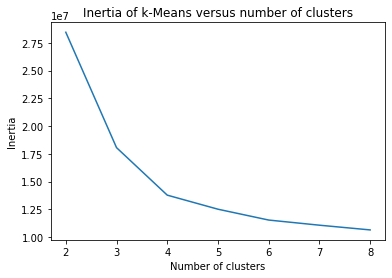

In [167]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
min_ = 2
max_ = 9
scores = [KMeans(n_clusters=i).fit(df_skills).inertia_ for i in range(min_,max_)]

from matplotlib import pyplot as plt
plt.plot(np.arange(min_, max_), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

**Graficamos el resultado kmedias con la cantidad de clases elegida: Visualizamos de a dos variables por vez**

In [168]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1='defending_standing_tackle' #skills_ratings[6]
skill_2='attacking_volleys' #skills_ratings[25]


kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Ckacks!!',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

plot(fig)

'temp-plot.html'

In [169]:
df_clusters=df_n.copy()
df_clusters['kmeans'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')

Kmeans encontró:  3 clusters, nosotros forzamos la cantidad


**EVALUACIÓN**

**EJERCICIO: Análisis exploratorio de los clusters, usando las clases asignadas por kmeans** 
- Cantidad de observaciones por Cluster
- Análisis descriptivo separando por Cluster
- Tabla de contingencia alguna categórica vs clusters
- Silohuette?


In [170]:
cl_count = df_clusters.groupby(['kmeans']).sofifa_id.count()
cl_rel = 100*cl_count/len(df_clusters)
pd.DataFrame({'Cantidad de muestras por cluster': cl_count, 'Tamaño relativo del cluster (representatividad) [%] ':cl_rel})

,Cantidad de muestras por cluster,Tamaño relativo del cluster (representatividad) [%]
kmeans,,
0,1932,40.622372
1,440,9.251472
2,2384,50.126156


In [171]:
# La primera opcion de las posiciones es la preferida por el jugador
df_clusters['prefered_position'] = df_clusters.player_positions.str.split(',').apply(lambda l: l[0])
# Las posiciones son muchas, asique las resumo en 4 -> arquero, defensor, mediocampo, delantero
df_clusters.prefered_position =  df_clusters.prefered_position.apply(lambda x: 'ARQUERO' if x in ['GK'] else x)
df_clusters.prefered_position =  df_clusters.prefered_position.apply(lambda x: 'DELANTERO' if x in ['ST','CF','RW','LW'] else x)
df_clusters.prefered_position =  df_clusters.prefered_position.apply(lambda x: 'MEDIOCAMPO' if x in ['CAM','RM','CM','RM','LM','CDM'] else x)
df_clusters.prefered_position =  df_clusters.prefered_position.apply(lambda x: 'DEFENSOR' if x in ['RWB','RB','CB','LB','LWB'] else x)

In [172]:
pd.crosstab(df_clusters.prefered_position, df_clusters.kmeans)

kmeans,0,1,2
prefered_position,,,
ARQUERO,0,440,0
DEFENSOR,5,0,1466
DELANTERO,979,0,7
MEDIOCAMPO,948,0,911


Aunque el Criterio del codo indique la cantidad de clusters optimos es de 4/5, es complicado llegar a una interpretacion clara de los resultados ya que los mediocampistas tienen skills similares a delanteros y defensores la barrera entre posiciones es confusa porque hay mucho solapamiento entre clusters.
Separando en tres clusters se obtiene una interpretacion mucho mas clara, como muestra la tabla de contingencia anterior casi no hay solapamiento si replanteamos la interpretacion como **arqueros**, **jugador de ataque** (juega en la parte superior) y **jugador de defensa** (juega en la parte baja), con la siguiente agregacion de posiciones especificas:
- GK -> ARQUERO
- ST,CF,RW,LW,CAM,LM,RM -> ATAQUE
- RWB,RB,CB,LB,LWB,CDM,CM -> DEFENSA

In [173]:
# La primera opcion de las posiciones es la preferida por el jugador
df_clusters['prefered_position_agg'] = df_clusters.player_positions.str.split(',').apply(lambda l: l[0])
# Las posiciones son muchas, asique las resumo en 4 -> arquero, defensor, mediocampo, delantero
df_clusters.prefered_position_agg =  df_clusters.prefered_position_agg.apply(lambda x: 'ARQUERO' if x in ['GK'] else x)
df_clusters.prefered_position_agg =  df_clusters.prefered_position_agg.apply(lambda x: 'ATAQUE' if x in ['ST','CF','RW','LW','CAM','LM','RM'] else x)
df_clusters.prefered_position_agg =  df_clusters.prefered_position_agg.apply(lambda x: 'DEFENSA' if x in ['RWB','RB','CB','LB','LWB','CDM','CM'] else x)
pd.crosstab(df_clusters.prefered_position_agg, df_clusters.kmeans)

kmeans,0,1,2
prefered_position_agg,,,
ARQUERO,0,440,0
ATAQUE,1787,0,79
DEFENSA,145,0,2305


# 4.-Clustering-Mean-Shift 

- NO es necesario definirle la cantidad de grupos/clusters
- NO es escalable, computacionalmente es muy pesado. Cada dato tienen un proceso iterativo en donde en cada iteración considera los vecinos a menos de un radio de distancia.
- Hipeparámetros: radio (de cobertura para cálculo de media)

In [233]:
from sklearn.cluster import KMeans,MeanShift,estimate_bandwidth
from sklearn import decomposition
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler(feature_range=(0,100))
mms.fit(df_skills)
df_scaled = mms.transform(df_skills)
bw = estimate_bandwidth(df_scaled)
print ('Estimated BW: {}'.format(bw))
ms = MeanShift(bandwidth=bw, bin_seeding=False)

ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Numero estimado de clusters para Mean Shift : %d" % n_clusters_)

# Etquetas de los elementos de los clusters


Estimated BW: 115.77802661529228


KeyboardInterrupt: 

In [ ]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1='defending_standing_tackle' #skills_ratings[6]
skill_2='attacking_volleys' #skills_ratings[25]



MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

plot(fig)

In [176]:
df_clusters['MeanShift'] = ms.labels_ #clusters2
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros lo forzamos')
print('Mean shift encontró ', max(ms.labels_)+1, 'clusters, según los hiperparámetros elegidos')

Kmeans encontró:  3 clusters, nosotros lo forzamos
Mean shift encontró  2 clusters, según los hiperparámetros elegidos


**EVALUACIÓN**

**EJERCICIO EN GRUPO: Análisis exploratorio de los clusters, usando las clases asignadas por MeanShift** 

In [177]:
#Cantidad de observaciones por Cluster
#Análisis descriptivo separando por Cluster
#Tabla de contingencia alguna categórica vs clusters
#Silohuette?


In [178]:
cl_count = df_clusters.groupby(['MeanShift']).sofifa_id.count()
cl_rel = 100*cl_count/len(df_clusters)
pd.DataFrame({'Cantidad de muestras por cluster': cl_count, 'Tamaño relativo del cluster (representatividad) [%] ':cl_rel})

,Cantidad de muestras por cluster,Tamaño relativo del cluster (representatividad) [%]
MeanShift,,
0,4316,90.748528
1,440,9.251472


In [179]:
# La primera opcion de las posiciones es la preferida por el jugador
df_clusters['prefered_position'] = df_clusters.player_positions.str.split(',').apply(lambda l: l[0])
# Las posiciones son muchas, asique las resumo en 4 -> arquero, defensor, mediocampo, delantero
df_clusters.prefered_position =  df_clusters.prefered_position.apply(lambda x: 'ARQUERO' if x in ['GK'] else x)
df_clusters.prefered_position =  df_clusters.prefered_position.apply(lambda x: 'DELANTERO' if x in ['ST','CF','RW','LW'] else x)
df_clusters.prefered_position =  df_clusters.prefered_position.apply(lambda x: 'MEDIOCAMPO' if x in ['CAM','RM','CM','RM','LM','CDM'] else x)
df_clusters.prefered_position =  df_clusters.prefered_position.apply(lambda x: 'DEFENSOR' if x in ['RWB','RB','CB','LB','LWB'] else x)

In [180]:
pd.crosstab(df_clusters.prefered_position, df_clusters.MeanShift)

MeanShift,0,1
prefered_position,,
ARQUERO,0,440
DEFENSOR,1471,0
DELANTERO,986,0
MEDIOCAMPO,1859,0


En su mejor esfuerzo Mean Shift solo puede encontrar dos clusters, Arqueros y el resto de los jugadores, incluso normalizando este resultado no cambia

**Pregunta: normalizamos/estandarizamos la base?**

No es necesario, todos los skills estan en un rango de 0 a 100

**Ahora vemos que agrupamientos podemos hacer excluyendo los arqueros**

# 5.-Clustering-con-Kmeans-sin-arqueros

In [205]:
df['prefered_position'] = df.player_positions.str.split(',').apply(lambda l: l[0])

In [234]:
n=10000

df_n=df.loc[:n]
df_n=df_n[(df_n["prefered_position"]!='GK')&(df_n['overall']>69)]

skills_ratings = skills_ratings = [#'age', 'height_cm', 'weight_kg',
       #'potential', #'value_eur', 'wage_eur',
       #'weak_foot', 'skill_moves',
       #'release_clause_eur',
       'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed',
       'gk_positioning', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes',]
df_skills=df_n[skills_ratings]
df_skills.fillna(0, inplace=True)

In [213]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

# Número de clusters buscado
n_clust = 3

km = KMeans(n_clusters=n_clust)
km.fit(df_skills)

# Recuperacion de etiquetas
clusters = km.labels_


Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

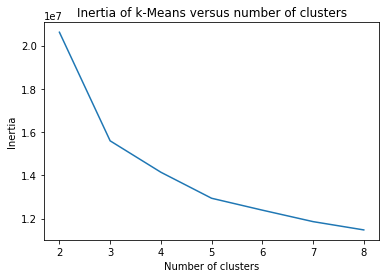

In [214]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
min_ = 2
max_ = 9
scores = [KMeans(n_clusters=i).fit(df_skills).inertia_ for i in range(min_,max_)]

from matplotlib import pyplot as plt
plt.plot(np.arange(min_, max_), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [217]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1='defending_standing_tackle' #skills_ratings[6]
skill_2='attacking_volleys' #skills_ratings[25]


kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

plot(fig)

'temp-plot.html'

In [218]:
df_clusters = df_n.copy()
df_clusters['kmeans'] = km.labels_ #clusters2

**Analisis**

In [219]:
cl_count = df_clusters.groupby(['kmeans']).sofifa_id.count()
cl_rel = 100*cl_count/len(df_clusters)
pd.DataFrame({'Cantidad de muestras por cluster': cl_count, 'Tamaño relativo del cluster (representatividad) [%] ':cl_rel})

,Cantidad de muestras por cluster,Tamaño relativo del cluster (representatividad) [%]
kmeans,,
0,1113,21.666342
1,1942,37.804166
2,2082,40.529492


In [222]:
# La primera opcion de las posiciones es la preferida por el jugador
df_clusters['prefered_position'] = df_clusters.player_positions.str.split(',').apply(lambda l: l[0])
# Las posiciones son muchas, asique las resumo en 4 -> arquero, defensor, mediocampo, delantero
df_clusters.prefered_position =  df_clusters.prefered_position.apply(lambda x: 'ARQUERO' if x in ['GK'] else x)
df_clusters.prefered_position =  df_clusters.prefered_position.apply(lambda x: 'DELANTERO' if x in ['ST','CF','RW','LW'] else x)
#df_clusters.prefered_position =  df_clusters.prefered_position.apply(lambda x: 'MEDIOCAMPO' if x in ['CAM','RM','CM','RM','LM','CDM'] else x)
df_clusters.prefered_position =  df_clusters.prefered_position.apply(lambda x: 'DEFENSOR' if x in ['RWB','RB','CB','LB','LWB'] else x)

In [223]:
pd.crosstab(df_clusters.prefered_position, df_clusters.kmeans)

kmeans,0,1,2
prefered_position,,,
CAM,0,307,102
CDM,105,0,414
CM,2,25,635
DEFENSOR,1006,0,767
DELANTERO,0,1114,32
LM,0,269,61
RM,0,227,71


Sucede lo mismo que en el analisis con arqueros, hacer tres clusters provoca mucho solapamiento, es mejor hacer dos clusters bien definidos
- GK -> ARQUERO
- ST,CF,RW,LW,CAM,LM,RM -> ATAQUE
- RWB,RB,CB,LB,LWB,CDM,CM -> DEFENSA

In [225]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

# Número de clusters buscado
n_clust = 2

km = KMeans(n_clusters=n_clust)
km.fit(df_skills)

# Recuperacion de etiquetas
clusters = km.labels_
df_clusters = df_n.copy()
df_clusters['kmeans_2'] = km.labels_ #clusters2

In [226]:
# La primera opcion de las posiciones es la preferida por el jugador
df_clusters['prefered_position_agg'] = df_clusters.player_positions.str.split(',').apply(lambda l: l[0])
# Las posiciones son muchas, asique las resumo en 4 -> arquero, defensor, mediocampo, delantero
df_clusters.prefered_position_agg =  df_clusters.prefered_position_agg.apply(lambda x: 'ARQUERO' if x in ['GK'] else x)
df_clusters.prefered_position_agg =  df_clusters.prefered_position_agg.apply(lambda x: 'ATAQUE' if x in ['ST','CF','RW','LW','CAM','LM','RM'] else x)
df_clusters.prefered_position_agg =  df_clusters.prefered_position_agg.apply(lambda x: 'DEFENSA' if x in ['RWB','RB','CB','LB','LWB','CDM','CM'] else x)
pd.crosstab(df_clusters.prefered_position_agg, df_clusters.kmeans_2)


kmeans_2,0,1
prefered_position_agg,,
ATAQUE,98,2085
DEFENSA,2791,163


# 6.-Clustering-Mean-Shift-sin-arqueros 

In [243]:
from sklearn.cluster import KMeans,MeanShift,estimate_bandwidth
from sklearn import decomposition
from sklearn.preprocessing import MinMaxScaler, StandardScaler

mms = MinMaxScaler(feature_range=(0,100))
#mms = StandardScaler()
mms.fit(df_skills)
df_scaled = mms.transform(df_skills)
bw = estimate_bandwidth(df_scaled)
print ('Estimated BW: {}'.format(bw))
ms = MeanShift(bandwidth=bw, bin_seeding=False)
ms.fit(df_scaled)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Numero de clusters encontrado por Mean Shift : %d" % n_clusters_)


Estimated BW: 115.84347450189371
Numero de clusters encontrado por Mean Shift : 2


In [244]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
#Eligo dos números entre 0 y  de n_skills-1
skill_1='defending_standing_tackle' #skills_ratings[6]
skill_2='attacking_volleys' #skills_ratings[25]


MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

plot(fig)

'temp-plot.html'

In [245]:
df_clusters=df_n.copy()
df_clusters['MeanShift'] = ms.labels_ #clusters2

**Análisis exploratorio de las clases**

In [246]:
cl_count = df_clusters.groupby(['MeanShift']).sofifa_id.count()
cl_rel = 100*cl_count/len(df_clusters)
pd.DataFrame({'Cantidad de muestras por cluster': cl_count, 'Tamaño relativo del cluster (representatividad) [%] ':cl_rel})

,Cantidad de muestras por cluster,Tamaño relativo del cluster (representatividad) [%]
MeanShift,,
0,5133,99.922134
1,4,0.077866


MeanShift no es capaz de diferenciar mas que un cluster grande, como paso con el item 4, nisiquiera normalizando o estandarizando es capaz de separar ese cluster.